In [80]:
import numpy as np
import heapq
from scipy.stats import gamma

class Particle:
    def __init__(self, death_x, birth_t, death_t, wk, ik, mark = 0, birth_x = 0):
        self.mark = mark
        self.birth_x = birth_x
        self.death_x = death_x
        self.birth_t = birth_t
        self.death_t = death_t
        self.wk = wk
        self.ik = ik
    

class BranchingProcess:
    def __init__(self, T=1.0, alpha=0.2, c = 0.15, d=5, x0=None, kappa=0.5, theta=2.5, n=96000, M=1000):
        self.T = T
        self.alpha = alpha
        self.b = np.linspace(1 + 1 / d, 2, d) / d
        self.c = c
        self.d = d
        self.sigma0 = 1 / np.sqrt(d)
        if x0 is None:
            self.x0 = np.full(d, 0.5)
        else:
            self.x0 = np.array(x0)
        self.kappa = kappa
        self.theta = theta
        self.n = n
        self.M = M
        self.reset()

    def reset(self):
        self.time = 0.0
        self.next_splitting_time = []
        split_time = min(np.random.gamma(shape = self.kappa, scale = self.theta), self.T)
        p0 = Particle(
            birth_x = self.x0,
            death_x= self.x0 + np.sqrt(split_time)*self.sigma0*np.random.normal(size=self.d),
            birth_t = 0, 
            death_t= split_time,
            wk= 1.0, mark = 0, ik = np.random.binomial(n = 1, p = 0.5)
            )
        heapq.heappush(self.next_splitting_time, (split_time, (1,)))
        self.population = {(1,): p0}

    def step(self):
        (tau, label) = heapq.heappop(self.next_splitting_time)
        tau = min(tau, self.T)
        self.time = tau
        if tau >= self.T:
            return
        parent = self.population[label]
        i = parent.ik
        if i == 1:
            l1,l2 = label + (1,), label + (2,)
            x = parent.death_x
            s1,s2 = np.random.gamma(shape = self.kappa, scale = self.theta, size = 2)
            death_t1,death_t2 = min(s1 + tau, self.T), min(s2 + tau,self.T) 
            i1,i2 = np.random.binomial(n = 1, p = 0.5, size = 2) 
            heapq.heappush(self.next_splitting_time, (death_t1, l1))
            heapq.heappush(self.next_splitting_time, (death_t2, l2))

            dw1 = np.sqrt(death_t1 - tau) * np.random.normal(size = self.d)
            child1 = Particle(
                mark = 0,
                birth_x = x,
                death_x = x + self.sigma0*dw1,
                birth_t= tau,
                death_t=death_t1,
                wk=1.0,
                ik=i1
            )
            self.population[l1] = child1
            
            dw2 = np.sqrt(death_t2 - tau)*np.random.normal(size = self.d)
            wbar =  dw2 / ((death_t2 - tau)*self.sigma0)
            wk = self.b @ wbar 
            child2 = Particle(
                mark = 1,
                birth_x=x,
                death_x=x + self.sigma0*dw2,
                birth_t=tau,
                death_t=death_t2, 
                wk=wk, 
                ik=i2
            )                    
            self.population[l2] = child2

    def cl(self,idx,t,x):
        if idx == 0:
            return np.cos(sum(x))*(
                self.alpha + self.sigma0**2 / 2 + self.c*np.sin(sum(x))*(3 * self.d + 1) / (2 * self.d) * np.exp(self.alpha * (self.T - t))
                ) * np.exp(self.alpha * (self.T - t))
        else:
            return self.c
    
    def fbar(self, t):
        return 1 - gamma.cdf(t, self.kappa, scale = self.theta)
    
    def rho(self, t):
        return gamma.pdf(t, self.kappa, scale = self.theta)
    
    def g(self,x):
        return np.cos(sum(x))
    
    def sample_process(self):
        self.reset()
        while self.time < self.T and len(self.next_splitting_time) > 0:
            self.step()

    def sample_psi(self):
        self.sample_process()
        res = 1
        for l in self.population:
            p = self.population[l]
            if p.death_t >= self.T:
                g1 = self.g(p.death_x)
                g2 = self.g(p.birth_x) if p.mark > 0 else 0
                f = self.fbar(p.death_t - p.birth_t)
                res *= (g1 - g2) * p.wk / f
            else:
                res *= self.cl(p.ik, p.death_t, p.death_x) * p.wk * 2 / (self.rho(p.death_t - p.birth_t))
        return res

    def sample_expectation_psi(self):
        res = 0
        for _ in range(self.n):
            self.reset()
            res += self.sample_psi()
        return res / self.n
    
    def global_estimate(self):
        samples = []
        for _ in range(self.M):
            samples.append(self.sample_expectation_psi())
        e = np.mean(samples)
        sd = np.std(samples, ddof=1)
        return e, sd
    
    def theoretical_value(self):
        return np.cos(sum(self.x0)) * np.exp(self.alpha * self.T)
                


In [78]:
bp = BranchingProcess()

bp.sample_process()

In [79]:
print("estimated value: ",bp.sample_expectation_psi())
print("theoretical value: ", bp.theoretical_value())

estimated value:  -0.7153208774548679
theoretical value:  -0.9785190217114356


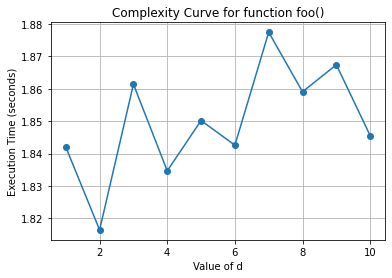

In [17]:
import timeit
import matplotlib.pyplot as plt

def foo(d):
    bp = BranchingProcess(d = d)
    bp.sample_psi()
    pass

# Define a range of values for parameter d
d_values = range(1, 11)  # Example: from 1 to 10

# Measure the execution time for each value of d
execution_times = []
for d in d_values:
    time_taken = timeit.timeit(lambda: foo(d), number = 1)
    execution_times.append(time_taken)

# Plot the curve of execution time against d
plt.plot(d_values, execution_times, marker='o')
plt.xlabel('Value of d')
plt.ylabel('Execution Time (seconds)')
plt.title('Complexity for estimating u(0,x0)')
plt.grid(True)
plt.show()



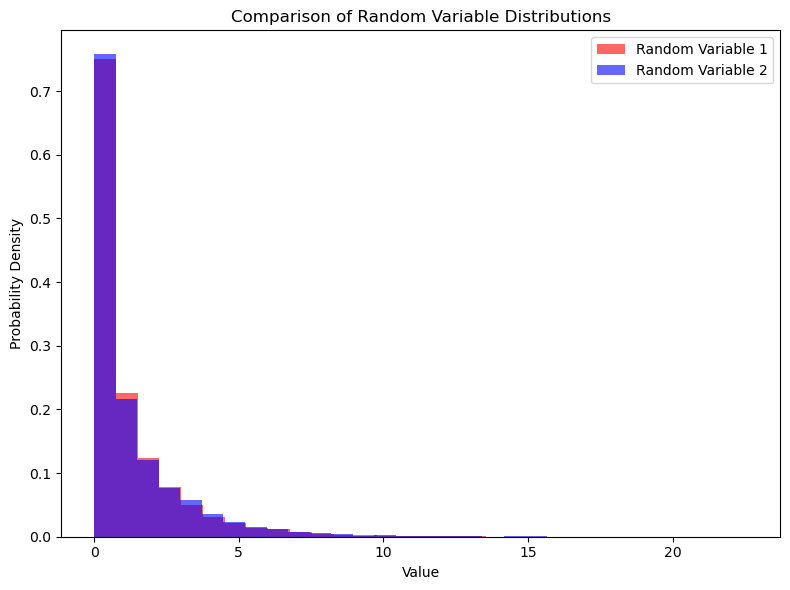

In [82]:
import matplotlib.pyplot as plt
import numpy as np

kappa = 0.5
theta = 2.5

def foo1():
    return np.random.gamma(shape = kappa, scale = theta)

def foo2():
    return gamma.rvs(kappa, scale = theta)

# Sample from the two random variables
sample_size = 10000
rv1_samples = [foo1() for _ in range(sample_size)]
rv2_samples = [foo2() for _ in range(sample_size)]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the histograms
ax.hist(rv1_samples, bins=30, density=True, alpha=0.6, color='r', label='Random Variable 1')
ax.hist(rv2_samples, bins=30, density=True, alpha=0.6, color='b', label='Random Variable 2')

# Add labels and legend
ax.set_title('Comparison of Random Variable Distributions')
ax.set_xlabel('Value')
ax.set_ylabel('Probability Density')
ax.legend()

# Adjust the layout
plt.tight_layout()
plt.show()